[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/atmos-cloud-sim-uj/PySDM-examples.git/main?urlpath=PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/atmos-cloud-sim-uj/PySDM-examples/blob/main/PySDM_examples/Lowe_et_al_2019/fig_2.ipynb)

#### based on Fig. 1 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install atmos-cloud-sim-uj-utils
    from atmos_cloud_sim_uj_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from matplotlib import pylab
import numpy as np
from PySDM.physics import si, Formulae, constants as const, spectra
from atmos_cloud_sim_uj_utils import show_plot
from PySDM_examples.Singer.aerosol import AerosolBetaCary

In [6]:
from PySDM.physics.surface_tension import compressed_film_ovadnevaite
compressed_film_ovadnevaite.sgm_org = 40 * si.mN / si.m
compressed_film_ovadnevaite.delta_min = 0.3 * si.nm

from PySDM.physics.surface_tension import compressed_film_ruehl
aer = AerosolBetaCary()
compressed_film_ruehl.nu_org = aer.aerosol_modes_per_cc['nu_org']
compressed_film_ruehl.A0 = 50e-20 * si.m * si.m
compressed_film_ruehl.C0 = 6e-7
compressed_film_ruehl.m_sigma = 1.05e-17 * si.J
compressed_film_ruehl.sgm_min = 40 * si.mN / si.m

# compressed_film_ruehl.A0 = 115e-20 * si.m * si.m # 115 A^2/molecule
# compressed_film_ruehl.C0 = np.exp(-4.0) 
# compressed_film_ruehl.m_sigma = 0.3e-17 * si.J
# compressed_film_ruehl.sgm_min = 40 * si.mN / si.m

# A0=115, ln(C0)=-4, and m=0.3
# MW_inorg = 132;  # ammonium sulfate
# MW_H2O = 0.018015;
# VHF_org = 1;     # vant hoff factor
# VHF_inorg = 2.6;
# pw = 997;
# rho_inorg = 1.77 * 1e3;  # kg m-3 
# MW_inorg = 0.13214;       # kg mol-1
# rho_org = 905;             # kg m-3
# MW_org = 0.20436;         # kg mol-1

In [9]:
cases = {
    'Beta Caryophyllene': AerosolBetaCary(),
    'Beta Caryophyllene': AerosolBetaCary()
}

formulae_bulk = Formulae(surface_tension='Constant')
formulae_ovad = Formulae(surface_tension='CompressedFilmOvadnevaite')
formulae_ruehl = Formulae(surface_tension='CompressedFilmRuehl')

r_wet = np.logspace(np.log(150 * si.nm), np.log(3000 * si.nm), base=np.e, num=100)
r_dry = 50 * si.nm
v_wet = formulae_ovad.trivia.volume(r_wet)
v_dry = formulae_ovad.trivia.volume(r_dry)
T=300 * si.K
r_wet_ticks_nm = (300, 500, 700, 1000, 3000)

In [10]:
from scipy.optimize import root, root_scalar
from scipy import constants as sci

nu_org = aer.aerosol_modes_per_cc['nu_org']
A0 = 120e-20 * si.m * si.m
C0 = 6e-8
sgm_min = 0.04

def sigma_SL(T, v_wet, v_dry, f_org):
    Cb_iso = (f_org*v_dry/nu_org) / (v_wet/const.nu_w) # = C_bulk / (1-f_surf)
    r_wet = ((3 * v_wet) / (4 * np.pi))**(1/3) # m - wet radius
    A_iso = (4*np.pi*r_wet**2) / (f_org*v_dry*sci.N_A/nu_org) # m^2 = A*f_surf

    f = lambda f_surf: A0/(A_iso/f_surf) - (Cb_iso*(1-f_surf)/C0)/(1 + (Cb_iso*(1-f_surf)/C0))
    sol = root(f, np.ones(len(v_wet)))
    f_surf = sol.x

    sgm = const.sgm_w - ((sci.R*T)/(A0*sci.N_A))*np.log(1 + Cb_iso*(1-f_surf)/C0)
    sgm = np.minimum(np.maximum(sgm, sgm_min), const.sgm_w)
    return sgm

### Surface tension

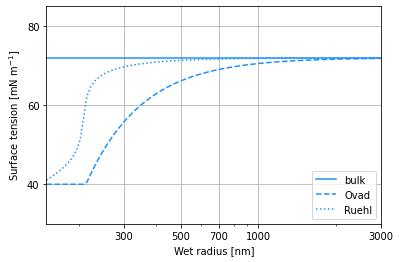

In [11]:
for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl}.items():
    if label == "bulk":
        linestyle='-'
    elif label == "Ovad":
        linestyle='--'
    elif label == "Ruehl":
        linestyle=':'
    else:
        linestyle='-.'
    for k, v in cases.items():
        sigma = np.zeros(len(v_wet))
        if label == "Ruehl":
            sigma = sigma_SL(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        elif label == "bulk":
            sigma = np.ones(len(v_wet)) * formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        pylab.plot(r_wet / si.nm, sigma / (si.mN / si.m), label=label, color=v.color, linestyle=linestyle)

pylab.grid()
pylab.xscale('log')
pylab.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
yticks = (20, 40, 60, 80)
pylab.yticks(yticks, yticks)
pylab.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pylab.ylim(30, 85)
pylab.xlabel('Wet radius [nm]')
pylab.ylabel('Surface tension [mN m$^{-1}$]')
pylab.legend()
pylab.show()
#show_plot()

### Kohler curves

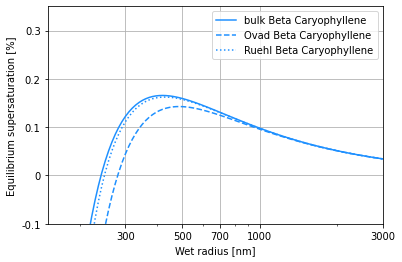

In [12]:
rd3 = r_dry**3

for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl}.items():
    for k, v in cases.items():
        if label == "Ruehl":
            sigma = sigma_SL(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        RH_eq = formulae.hygroscopicity.RH_eq(r_wet, T, v.aerosol_modes_per_cc['kappa'][label], rd3, sigma)
        if label == "bulk":
            linestyle='-'
        elif label == "Ovad":
            linestyle='--'
        elif label == "Ruehl":
            linestyle=':'
        else:
            linestyle='-.'
        pylab.plot(
            r_wet / si.nm, 
            (RH_eq - 1)*100, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=linestyle
        )
pylab.grid()
pylab.xscale('log')
pylab.xticks(r_wet_ticks_nm, r_wet_ticks_nm)
pylab.xlabel('Wet radius [nm]')
pylab.xlim(r_wet[0] / si.nm, r_wet[-1] / si.nm)
pylab.ylabel('Equilibrium supersaturation [%]')
yticks = (-.1, 0, .1, .2, .3)
pylab.yticks(yticks, yticks)
pylab.ylim(yticks[0], .35)
pylab.legend()
pylab.show()
#show_plot()

### Critical radius

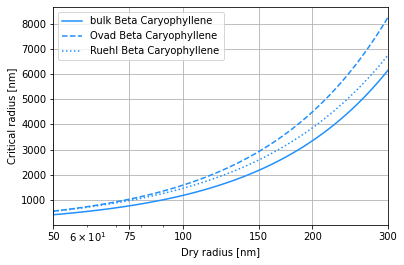

In [28]:
r_dry = np.logspace(np.log(50 * si.nm), np.log(300 * si.nm), base=np.e, num=100)
v_dry = formulae_ovad.trivia.volume(r_dry)
rd3 = r_dry**3

for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl}.items():
    for k, v in cases.items():
        if label == "Ruehl":
            sigma = sigma_SL(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        rcrit = formulae.hygroscopicity.r_cr(v.aerosol_modes_per_cc['kappa'][label], rd3, T, sigma)
        
        if label == "bulk":
            linestyle='-'
        elif label == "Ovad":
            linestyle='--'
        elif label == "Ruehl":
            linestyle=':'
        else:
            linestyle='-.'
        pylab.plot(
            r_dry / si.nm, 
            rcrit / si.nm, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=linestyle
        )
pylab.grid()
pylab.xscale('log')
r_dry_ticks_nm = (50, 75, 100, 150, 200, 300)
pylab.xticks(r_dry_ticks_nm, r_dry_ticks_nm)
pylab.xlabel('Dry radius [nm]')
pylab.xlim(r_dry[0] / si.nm, r_dry[-1] / si.nm)
pylab.ylabel('Critical radius [nm]')
#yticks = (-.1, 0, .1, .2, .3)
#pylab.yticks(yticks, yticks)
#pylab.ylim(yticks[0], .35)
pylab.legend()
pylab.show()
#show_plot()

### Effective Hygroscopicity, $\kappa_{eff}$

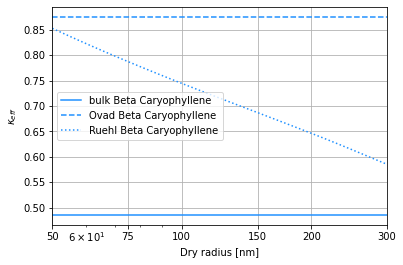

In [34]:
for label, formulae in {'bulk': formulae_bulk, 'Ovad': formulae_ovad, 'Ruehl': formulae_ruehl}.items():
    for k, v in cases.items():
        if label == "Ruehl":
            sigma = sigma_SL(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        else:
            sigma = formulae.surface_tension.sigma(T, v_wet, v_dry, v.aerosol_modes_per_cc['f_org'])
        rcrit = formulae.hygroscopicity.r_cr(v.aerosol_modes_per_cc['kappa'][label], rd3, T, sigma)
        kappa = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * sigma
        kap_eff = (2 * rcrit**2) / (3 * r_dry**3 * const.Rv * T * const.rho_w) * const.sgm_w
        
#         print(label)
#         print(v.aerosol_modes_per_cc['kappa'][label])
#         print(sigma)
#         print(kap_eff)
        
        if label == "bulk":
            linestyle='-'
        elif label == "Ovad":
            linestyle='--'
        elif label == "Ruehl":
            linestyle=':'
        else:
            linestyle='-.'
        pylab.plot(
            r_dry / si.nm, 
            kap_eff, 
            label=f"{label} {k}", 
            color=v.color, 
            linestyle=linestyle
        )
pylab.grid()
pylab.xscale('log')
pylab.xticks(r_dry_ticks_nm, r_dry_ticks_nm)
pylab.xlabel('Dry radius [nm]')
pylab.xlim(r_dry[0] / si.nm, r_dry[-1] / si.nm)
pylab.ylabel('$\kappa_{eff}$')
#yticks = (-.1, 0, .1, .2, .3)
#pylab.yticks(yticks, yticks)
#pylab.ylim(yticks[0], .35)
pylab.legend()
pylab.show()
#show_plot()

### Aerosol size distribution

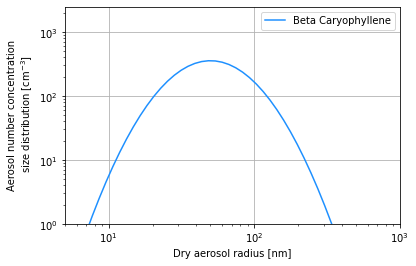

In [14]:
x = np.logspace(np.log(5 * si.nm), np.log(1000 * si.nm), base=np.e)
for k, v in cases.items():
    spec = v.aerosol_modes_per_cc['spectrum']
    pylab.loglog(x / si.nm, spec.size_distribution(x)*x / si.cm**-3, label=k, color=v.color)
pylab.ylim(1, 2500)
pylab.xlim(5, 1000)
pylab.legend()
pylab.grid()
pylab.xlabel('Dry aerosol radius [nm]')
pylab.ylabel('Aerosol number concentration\n size distribution [cm$^{-3}$]')
pylab.show()
#show_plot()